In [109]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime
from urllib.parse import urlparse

import torch
from transformers import BertTokenizer, BertLMHeadModel

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import numpy as np
import os
nltk.download("stopwords")
from nltk.corpus import stopwords
stopword=nltk.corpus.stopwords.words('english')
nltk.download("wordnet")
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import coherencemodel
# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
import re, nltk,gensim
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/genresell/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/genresell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/genresell/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/genresell/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/genresell/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [110]:
urls = [
    'https://www.wsj.com/',
    'https://www.cnn.com/',
    'https://www.nytimes.com/',
    'https://www.theguardian.com/international',
    'https://www.reuters.com/news/world'
]

In [111]:
# Initialize an empty list to store the scraped data
articles = []

In [112]:
for url in urls:
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    articles += soup.find_all('article')

In [113]:
data = []
for article in articles:
    article_url = article.find('a')['href']
    if not article_url.startswith('http'):
        article_url = f'https://{urlparse(url).netloc}{article_url}'

    title = article.find('h3')
    if title:
        title = title.text.strip()

    date = article.find('time')
    if date:
        try:
            date = datetime.strptime(date['datetime'], '%Y-%m-%dT%H:%M:%S.%fZ')
            date = date.strftime('%Y-%m-%d %H:%M:%S')
        except ValueError:
            date = None

    author = article.find('span', class_='c-byline__name')
    if author:
        author = author.text.strip()

    content = ''
    content_url = article_url
    content_response = requests.get(content_url)
    content_soup = BeautifulSoup(content_response.content, 'html.parser')
    paragraphs = content_soup.find_all('p')
    for paragraph in paragraphs:
        content += paragraph.text

    data.append({
        'title': title,
        'date': date,
        'author': author,
        'content': content,
        'url': article_url
    })

In [114]:
df = pd.DataFrame(data)
print(df.tail())

                                                title  date author   
20  Senior US lawmaker says doing everything possi...  None   None  \
21  Robert Kennedy Jr to make 2024 Democratic pres...  None   None   
22  Unstable markets drag Canadian M&A, debt issua...  None   None   
23  UBS CEO tells Credit Suisse staff to stay focu...  None   None   
24  UK antitrust regulator looks at Amazon's takeo...  None   None   

                                              content   
20  [1/5] Michael McCaul, Chairman of the U.S. Hou...  \
21  [1/2] Robert F. Kennedy Jr. and his wife actor...   
22  TORONTO, April 6 (Reuters) - Canadian dealmake...   
23  [1/2] Sergio Ermotti, newly rehired CEO of UBS...   
24  LONDON, April 6 (Reuters) - Britain is to inve...   

                                                  url  
20  https://www.reuters.com/article/taiwan-usa/sen...  
21  https://www.reuters.com/article/usa-election-k...  
22  https://www.reuters.com/article/canada-deals/u...  
23  https://

In [115]:
# load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertLMHeadModel.from_pretrained('bert-base-uncased')

If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [116]:
# define function to preprocess text data for BERT
def preprocess_text(text):
    # tokenize text
    tokenized_text = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        truncation=True,
        max_length=127,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )

    return tokenized_text

In [117]:
# define function to generate summary using BERT
def generate_summary(text):
    # preprocess text
    tokenized_text = preprocess_text(text)

    # generate summary
    summary_ids = model.generate(
        input_ids=tokenized_text['input_ids'],
        attention_mask=tokenized_text['attention_mask'],
        max_length=128,
        num_beams=4,
        early_stopping=True
    )

    # decode summary
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return summary

In [118]:
# preprocess content and generate summary for each article in dataframe
df['content_preprocessed'] = df['content'].apply(preprocess_text)
df['summary'] = df['content'].apply(generate_summary)

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le

In [119]:
# view final dataframe with summary column added
print(df.tail())

                                                title  date author   
20  Senior US lawmaker says doing everything possi...  None   None  \
21  Robert Kennedy Jr to make 2024 Democratic pres...  None   None   
22  Unstable markets drag Canadian M&A, debt issua...  None   None   
23  UBS CEO tells Credit Suisse staff to stay focu...  None   None   
24  UK antitrust regulator looks at Amazon's takeo...  None   None   

                                              content   
20  [1/5] Michael McCaul, Chairman of the U.S. Hou...  \
21  [1/2] Robert F. Kennedy Jr. and his wife actor...   
22  TORONTO, April 6 (Reuters) - Canadian dealmake...   
23  [1/2] Sergio Ermotti, newly rehired CEO of UBS...   
24  LONDON, April 6 (Reuters) - Britain is to inve...   

                                                  url   
20  https://www.reuters.com/article/taiwan-usa/sen...  \
21  https://www.reuters.com/article/usa-election-k...   
22  https://www.reuters.com/article/canada-deals/u...   
23  http

In [120]:
analyzer = SentimentIntensityAnalyzer()
df['sentiment_scores'] = df['summary'].apply(lambda x: analyzer.polarity_scores(x))

In [121]:
def get_sentiment_label(compound_score):
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [122]:
df['sentiment_label'] = df['sentiment_scores'].apply(lambda x: get_sentiment_label(x['compound']))

In [123]:
# view final dataframe with sentiment scores column added
print(df.tail())

                                                title  date author   
20  Senior US lawmaker says doing everything possi...  None   None  \
21  Robert Kennedy Jr to make 2024 Democratic pres...  None   None   
22  Unstable markets drag Canadian M&A, debt issua...  None   None   
23  UBS CEO tells Credit Suisse staff to stay focu...  None   None   
24  UK antitrust regulator looks at Amazon's takeo...  None   None   

                                              content   
20  [1/5] Michael McCaul, Chairman of the U.S. Hou...  \
21  [1/2] Robert F. Kennedy Jr. and his wife actor...   
22  TORONTO, April 6 (Reuters) - Canadian dealmake...   
23  [1/2] Sergio Ermotti, newly rehired CEO of UBS...   
24  LONDON, April 6 (Reuters) - Britain is to inve...   

                                                  url   
20  https://www.reuters.com/article/taiwan-usa/sen...  \
21  https://www.reuters.com/article/usa-election-k...   
22  https://www.reuters.com/article/canada-deals/u...   
23  http

In [124]:
# Count the number of articles in each sentiment category
sentiment_counts = df['sentiment_label'].value_counts()

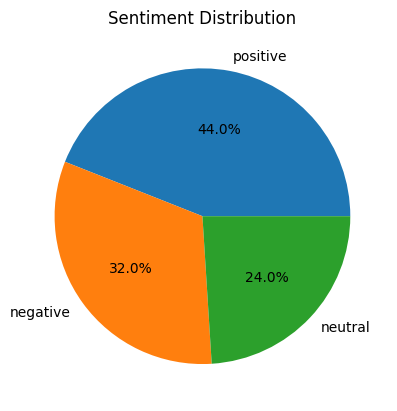

In [125]:
# Visualize the sentiment counts using a pie chart
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title('Sentiment Distribution')
plt.show()

In [126]:
import re 
def preprocess_text(text):
    text = re.sub('((www\.[^\s]+)|-(https?://[^\s]+))',' ', text)
    text = re.sub('@[^\s]+',' ', text)
    text = text.lower().replace("ё", "е")
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(r'\d+','', text)
    text = re.sub(r'\b\w{1,3}\b', '', text)
    return text.strip()

In [127]:
df["cleaned"]=df["summary"].apply(preprocess_text)

In [128]:
#Removing extra unnecessary words.
new_stopwords=['april', 'reuters', 'april reuters']

In [129]:
stopword.extend(new_stopwords)

In [130]:
#Remove stopword
df["cleaned"]=df["cleaned"].apply(lambda x: " ".join(x for x in x.split() if x not in stopword))
df["cleaned"]

0     membershipcustomer servicetools featuresadsmor...
1     membershipcustomer servicetools featuresadsmor...
2     membershipcustomer servicetools featuresadsmor...
3     membershipcustomer servicetools featuresadsmor...
4     membershipcustomer servicetools featuresadsmor...
5     membershipcustomer servicetools featuresadsmor...
6                         please enable disable blocker
7     london francisco tesla assures millions electr...
8     washington economy likely continued churn jobs...
9     hiring sign displayed outside taylor party equ...
10    signage fair seen avenue release jobs report m...
11    york federal reserve preferred bond market sig...
12    york federal reserve lending financial institu...
13    kyiv russian forces likely seized centre fierc...
14    beijing taipei china imposed sanctions hsiao k...
15    guangzhou hong kong china jinping given french...
16    apple aapl said tuesday filed lawsuit israeli ...
17    francisco november story corrected clarify

In [131]:
#Normalization
lemma = WordNetLemmatizer()
df["cleaned"]=df["cleaned"].apply(lambda x: "".join(lemma.lemmatize(w) for w in x))
data_lemmatized=df["cleaned"]

In [132]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=1,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',
                             ngram_range=(1,3)  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [133]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  4.393773664282709 %


In [134]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='batch',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

In [135]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
print(lda_model.get_params())

Log Likelihood:  -22469.604144466342
Perplexity:  3525.5616509481492
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 20, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 100, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [136]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 15, 20, 25, 30]})

In [137]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -11595.215987232215
Model Perplexity:  3348.4156750243324


In [138]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25, 30]
log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.5]
log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.7]
log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.9]

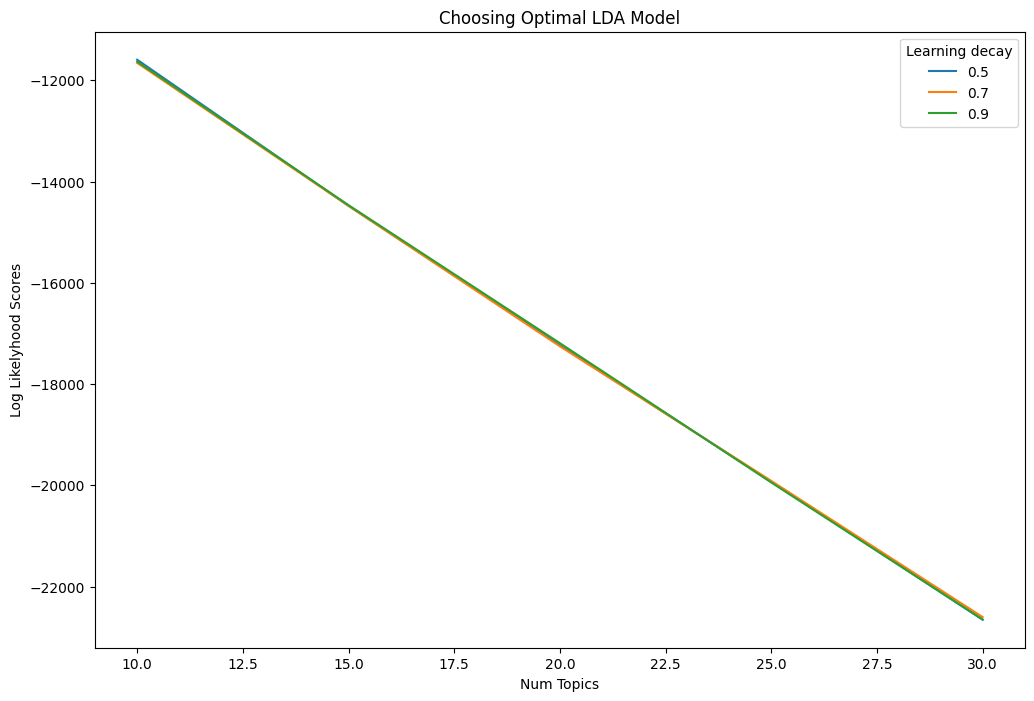

In [139]:
# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [140]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.010000,0.010000,0.010000,0.940000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,3
Doc1,0.010000,0.010000,0.010000,0.940000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,3
Doc2,0.010000,0.010000,0.010000,0.940000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,3
Doc3,0.010000,0.010000,0.010000,0.940000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,3
Doc4,0.010000,0.010000,0.010000,0.940000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,3
Doc5,0.010000,0.010000,0.010000,0.940000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,3
Doc6,0.870000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0
Doc7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.990000,0.000000,0.000000,0.000000,6
Doc8,0.000000,0.000000,0.000000,0.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
Doc9,0.000000,0.000000,0.000000,0.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3


In [141]:
df = df.set_index(df_document_topics.index)

In [142]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,3,9
1,0,4
2,1,3
3,4,3
4,2,2
5,6,1
6,8,1
7,5,1
8,7,1


In [143]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names_out()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,aapl,aapl said,aapl said tuesday,abates,abates global,abates global central,abuse,abuse apple,abuse apple latest,according,...,york federal reserve,young,young black,young black legislators,zoom,zoom roughly,zoom roughly thirds,zurich,zurich switzerland,zurich switzerland march
Topic0,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,1.1,...,0.1,0.1,0.1,0.1,1.1,1.1,1.1,1.1,1.1,1.1
Topic1,0.1,0.1,0.1,1.1,1.1,1.1,0.1,0.1,0.1,1.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
Topic2,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
Topic3,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,1.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
Topic4,1.1,1.1,1.1,0.1,0.1,0.1,1.1,1.1,1.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


In [144]:
# Show top 15 keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords["Topic"]= [str(i+1) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords["keywords"]=topic_keywords
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Topic,keywords
0,kennedy,workers,news,signed,eligible workers signed,eligible workers,thirds,mapbox,organizing,roughly,startup,roughly thirds,workers signed cards,workers signed,cards,1,"[kennedy, workers, news, signed, eligible work..."
1,quarter,billion,revenue,dell,banks,demand,banking,home,companies,states,united,united states,estimates,quarter revenue,work,2,"[quarter, billion, revenue, dell, banks, deman..."
2,taiwan,forces,russian forces,russian,bakhmut,friday,city,said,eastern,ukrainian,ukraine,said friday,parliament,long,told,3,"[taiwan, forces, russian forces, russian, bakh..."
3,products,featuresadsmoredow jones,membershipcustomer servicetools,servicetools,servicetools featuresadsmoredow jones,featuresadsmoredow,servicetools featuresadsmoredow,membershipcustomer servicetools featuresadsmor...,jones products products,products products,membershipcustomer,featuresadsmoredow jones products,jones products,jones,bank,4,"[products, featuresadsmoredow jones, membershi..."
4,said,apple,maker,competition,group,beijing,devices,china,leaders,guangzhou,macron,pegasus,britain,irobot,president,5,"[said, apple, maker, competition, group, beiji..."
5,market,economic,lows,plunged,treasury,forward,signal,market signal,bond market signal,bond market,bond,spread,week,central,york,6,"[market, economic, lows, plunged, treasury, fo..."
6,tesla,employees,cameras,privacy,customers,according,internal,london,groups,francisco,invasive videos images,invasive,videos,cameras builds,vehicles,7,"[tesla, employees, cameras, privacy, customers..."
7,representatives,house,democratic,came,justin,control,tennessee,protest,jones,week,thursday,latest,white,stood,justin jones justin,8,"[representatives, house, democratic, came, jus..."
8,claims,data,report,labor,week,thursday,september,department,unemployment,labor market,continued,jobs,labor department,seen,showed,9,"[claims, data, report, labor, week, thursday, ..."
9,disable blocker,blocker,enable disable blocker,enable disable,disable,enable,jones,membershipcustomer servicetools,products products,membershipcustomer servicetools featuresadsmor...,membershipcustomer,jones products products,jones products,featuresadsmoredow jones products,servicetools,10,"[disable blocker, blocker, enable disable bloc..."


In [145]:
df1=df_document_topics.data

In [146]:
df1.columns

Index(['Topic0', 'Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6',
       'Topic7', 'Topic8', 'Topic9', 'dominant_topic'],
      dtype='object')

In [147]:
df['Topics']=df1['dominant_topic']
df['Topics']

Doc0     3
Doc1     3
Doc2     3
Doc3     3
Doc4     3
Doc5     3
Doc6     0
Doc7     6
Doc8     3
Doc9     3
Doc10    8
Doc11    5
Doc12    3
Doc13    2
Doc14    1
Doc15    4
Doc16    4
Doc17    0
Doc18    1
Doc19    7
Doc20    2
Doc21    0
Doc22    1
Doc23    0
Doc24    4
Name: Topics, dtype: int64

In [148]:
df.head()

,title,date,author,content,url,content_preprocessed,summary,sentiment_scores,sentiment_label,cleaned,Topics
Doc0,None,None,None,WSJ MembershipCustomer ServiceTools & Features...,https://www.wsj.com/articles/do-older-workers-...,"[input_ids, attention_mask]",wsj membershipcustomer servicetools & features...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,membershipcustomer servicetools featuresadsmor...,3
Doc1,None,None,None,WSJ MembershipCustomer ServiceTools & Features...,https://www.wsj.com/articles/stocks-havent-loo...,"[input_ids, attention_mask]",wsj membershipcustomer servicetools & features...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,membershipcustomer servicetools featuresadsmor...,3
Doc2,None,None,None,WSJ MembershipCustomer ServiceTools & Features...,https://www.wsj.com/articles/after-her-husband...,"[input_ids, attention_mask]",wsj membershipcustomer servicetools & features...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,membershipcustomer servicetools featuresadsmor...,3
Doc3,None,None,None,WSJ MembershipCustomer ServiceTools & Features...,https://www.wsj.com/video/series/in-depth-feat...,"[input_ids, attention_mask]",wsj membershipcustomer servicetools & features...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,membershipcustomer servicetools featuresadsmor...,3
Doc4,None,None,None,WSJ MembershipCustomer ServiceTools & Features...,https://www.wsj.com/video/series/on-the-news/j...,"[input_ids, attention_mask]",wsj membershipcustomer servicetools & features...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,membershipcustomer servicetools featuresadsmor...,3


In [149]:
df_topic_keywords['Topics']=df_topic_keywords['Topic']

In [150]:
df.rename(columns={"Final Topic":'Final_Topic'},inplace=True)
df_topic_keywords.rename(columns={"Final_Topic":'Final_Topic_1'},inplace=True)

In [151]:
df_topic_keywords['Topics']=df_topic_keywords['Topics'].astype(int)
df['Topics']=df['Topics'].astype(int)

In [152]:
data_2=pd.merge(df,df_topic_keywords[['Topics','keywords']],left_on = 'Topics',right_on= 'Topics',how='left')

In [153]:
data_2.tail()

,title,date,author,content,url,content_preprocessed,summary,sentiment_scores,sentiment_label,cleaned,Topics,keywords
20,Senior US lawmaker says doing everything possi...,None,None,"[1/5] Michael McCaul, Chairman of the U.S. Hou...",https://www.reuters.com/article/taiwan-usa/sen...,"[input_ids, attention_mask]","[ 1 / 5 ] michael mccaul, chairman of the u. s...","{'neg': 0.053, 'neu': 0.947, 'pos': 0.0, 'comp...",negative,michael mccaul chairman house foreign affairs ...,2,"[quarter, billion, revenue, dell, banks, deman..."
21,Robert Kennedy Jr to make 2024 Democratic pres...,None,None,[1/2] Robert F. Kennedy Jr. and his wife actor...,https://www.reuters.com/article/usa-election-k...,"[input_ids, attention_mask]",[ 1 / 2 ] robert f. kennedy jr. and his wife a...,"{'neg': 0.022, 'neu': 0.925, 'pos': 0.053, 'co...",positive,robert kennedy wife actor cheryl hines arrive ...,0,NaN
22,"Unstable markets drag Canadian M&A, debt issua...",None,None,"TORONTO, April 6 (Reuters) - Canadian dealmake...",https://www.reuters.com/article/canada-deals/u...,"[input_ids, attention_mask]","toronto, april 6 ( reuters ) - canadian dealma...","{'neg': 0.145, 'neu': 0.761, 'pos': 0.094, 'co...",negative,toronto canadian dealmakers optimistic return ...,1,"[kennedy, workers, news, signed, eligible work..."
23,UBS CEO tells Credit Suisse staff to stay focu...,None,None,"[1/2] Sergio Ermotti, newly rehired CEO of UBS...",https://www.reuters.com/article/global-banks-c...,"[input_ids, attention_mask]","[ 1 / 2 ] sergio ermotti, newly rehired ceo of...","{'neg': 0.057, 'neu': 0.879, 'pos': 0.063, 'co...",positive,sergio ermotti newly rehired group attends new...,0,NaN
24,UK antitrust regulator looks at Amazon's takeo...,None,None,"LONDON, April 6 (Reuters) - Britain is to inve...",https://www.reuters.com/article/britain-antitr...,"[input_ids, attention_mask]","london, april 6 ( reuters ) - britain is to in...","{'neg': 0.0, 'neu': 0.916, 'pos': 0.084, 'comp...",positive,london britain investigate amazon anticipated ...,4,"[products, featuresadsmoredow jones, membershi..."
